<a href="https://colab.research.google.com/github/luisanovaes/ufam_project/blob/main/%5BLuisa%5D_Topification_results_PT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Acesso ao drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model New docs

Import ans install libs

In [2]:
!pip install preprocessing
!pip install bertopic==0.12.0
!pip install gensim==4.2.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.6/349.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... canceledERROR: Operation cancelled by user
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 59.5 MB/s eta 0:00:00
  Installing build dependencies ... canceled
ERROR: Operation cancelled by user
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 61.2 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.1
    Uninstalling gensim-4.3.1:
      Successfully uninstalled gensi

In [ ]:
from gensim.models.doc2vec import Doc2Vec
from nltk.tokenize import word_tokenize
import re
import unicodedata
import nltk
nltk.download('punkt')
from urllib.parse import urlparse
from sklearn.feature_extraction.text import CountVectorizer
from glob2 import glob
from bs4 import BeautifulSoup, Tag
from datetime import datetime
import spacy
import argparse
import pandas as pd
from sentence_transformers import SentenceTransformer
from IPython.display import display


# prepare data to run topic modeling solution
class PreprocessingData:
    def __init__(self, min_df=1, max_df=0.75, token_pattern=r"[a-zA-Z]\w*"): ##Mexer nisso?
        self.min_df = min_df
        self.max_df = max_df
        self.token_pattern = token_pattern
        # list of stop words in portuguese
        nltk.download('stopwords')
        self.en_stopwords = nltk.corpus.stopwords.words('portuguese') # Mudado 
         # Add stopwords 
        self.en_stopwords.extend(['agrg']) 
        self.en_stopwords.extend(['edcl'])  # Add 'refd' as stopword 
        self.en_stopwords.extend(['agint'])
        self.en_stopwords.extend(['inteiro teor'])
        self.en_stopwords.extend(['aresp'])        
        self.en_stopwords.extend(['hc'])



    def remove_punctuation(self, text):
        """
        Remove punctuations

        :parameters:
            text: sentence (string)

        :return: preprocessed documents without punctuations
        """
        punctuation = r'[/.!$%^&#*+\'\"()-.,:;<=>?@[\]{}|]'
        return re.sub(punctuation, '', text)

    def strip_accents_from_word(self, text):
        """
        Strip accents from input String.

        :parameters:
            text: word (string)

        :return: preprocessed word without accent
         """
        text = unicodedata.normalize('NFD', text)
        text = text.encode('ascii', 'ignore')
        text = text.decode("utf-8")
        return str(text)

    def strip_accents(self, text):
        """
        Strip accents from text.

        :parameters:
            text: sentence (string)

        :return: preprocessed documents without accent
         """
        return " ".join([self.strip_accents_from_word(word) for word in text.split()])

    def remove_URL(self, text):
        """
        Remove URLs from text
        :return: text without URLs
        """
        return re.sub(r"<.*?>", " ", text)

    def clean_text(self, documents):
        """
        Clean (preprocess) text data: parse URL, remove punctuation, convert to lowercase, remove stopword, and
        strip accents
        :param documents: list of documents
        :return: preprocessed_text: list of preprocessed documents
        """
        # preprocess jusbrasil URLs
        preprocessed_text = []
        for text in documents:
            preprocessed_text.append(self.remove_URL(text))
        # We have to decide whether we want to remove or keep punctuation
        # agravodeinstrumentoai70068698984rs or lei_de_criacao_do_pis_lei_complementar_7_70
        preprocessed_text = [self.remove_punctuation(doc) for doc in preprocessed_text]
        # convert to lowercase
        preprocessed_text = [doc.lower() for doc in preprocessed_text]
        # remove stopwords
        preprocessed_text = [' '.join([w for w in doc.split() if len(w) > 1 and w not in self.en_stopwords])
                             for doc in preprocessed_text]
        # strip accents
        # preprocessed_text = [self.strip_accents(doc) for doc in preprocessed_text]
        return preprocessed_text

    def prepare_text_for_topicmodel(self, documents, list_doc_ids):
        """
        Prepare data for BERTopic topic discovery
        :param documents: list of documents
        :param list_doc_ids: list of documents' ids
        :return: preprocessed_docs: list of preprocessed documents
                 ids_docs_removed: list of ids to be removed
        """
        # clean the data: parser URL, lowercase, remove punctuation, and remove stopwords
        preprocessed_docs_tmp = self.clean_text(documents)

        # stop_word = None. Stopwords were removed in clean_text()
        vectorizer = CountVectorizer(stop_words=None,
                                     tokenizer=None,
                                     min_df=self.min_df,
                                     max_df=self.max_df,
                                     ngram_range=(1, 2),
                                     token_pattern=self.token_pattern,
                                     lowercase=True)

        vectorizer.fit_transform(preprocessed_docs_tmp)
        vocabulary = set(vectorizer.get_feature_names_out())

        preprocessed_docs_tmp = [' '.join([w for w in doc.split() if w.lower() in vocabulary])
                                 for doc in preprocessed_docs_tmp]

        list_ids_removed = []
        preprocessed_docs, unpreprocessed_docs = [], []
        for i, doc in enumerate(preprocessed_docs_tmp):
            if len(doc) > 0:
                preprocessed_docs.append(doc)
                unpreprocessed_docs.append(documents[i])
            else:
                list_ids_removed.append(list_doc_ids[i])

        return preprocessed_docs, list_ids_removed


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec
import numpy as np
from bertopic import BERTopic
import pandas as pd


def doc2vec_infer(corpus, path_to_embed_model):
    """
    Given a list of documents, return a doc2vec embeddding for each document
    :param corpus: documents to be vectorized
    :param path_to_embed_model: path to doc2vec pre-trained model
    :return: embedding_model: doc2vec model
             embedding: document embeddings
    """
    # load doc2vec model
    d2v_model = Doc2Vec.load(path_to_embed_model)
    embedding_model = d2v_model.wv
    tokenized_doc = [word_tokenize(d, language='english') for d in corpus]

    #doc_infer = d2v_model.infer_vector(tokenized_doc[0], steps=40)
    doc_infer = d2v_model.infer_vector(tokenized_doc[0])
    embedding = [doc_infer]
    for document in tokenized_doc[1:]:
        doc_infer = d2v_model.infer_vector(document)
        #doc_infer = d2v_model.infer_vector(document, steps=40)
        embedding = np.append(embedding, [np.array(doc_infer)], axis=0)
    return embedding_model, embedding


def topify_new_docs(documents, doc_ids_list, path_to_tm_model, path_to_doc2vec_model, path_to_topic_csv,path_to_doc_csv):

    """
    Classify documents into topics from a pre-trained topic discover model
    :param documents: list of documents to be "topified/classified" according to the pre-trained topic discovery model
    :param doc_ids_list: list of documents' ids (can be a simple range[0:])
    :param path_to_tm_model: path to the pre-trained topic discovery model
    :param path_to_doc2vec_model: path to the pre-trained doc2vec model
    :param path_to_topic_csv: path to the output csv file containing topics (list of keywords)
    :param path_to_doc_csv: path to the csv file containing all documents and their respective topics
    """
    return

class LoadData:
    def load_data(self):
        documents = []
        list_of_ids = []
        i=0
      
        mypath = '/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/sbbd_decisoes_stj/documents/teste_2/'
        for txt in glob(os.path.join(mypath, '*.txt')):
          with open(txt, encoding='utf-8') as tfile:
            text = tfile.read()         
            text = text.replace('\n',' ').replace('FRAGMENT_SUPPRESSED','')
            documents.append(text)
            list_of_ids.append(txt)
            list_of_ids[:] = [d.replace('/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/sbbd_decisoes_stj/documents/teste_2/','') for d in list_of_ids]
     
        return documents, list_of_ids


## Code

In [ ]:
from glob import glob
import os

#Topic Modeling

### Load Data.
ld = LoadData()
#load data (documents and lista of ids)
documents, list_of_ids = ld.load_data()

# preprocessing documents
dc = PreprocessingData(min_df=1, max_df=0.75, token_pattern=r'\b[a-zA-Z]{2,}\b')
preprocessed_corpus, ids_docs_removed = dc.prepare_text_for_topicmodel(documents, list_of_ids)

##Load models to run tests with new data
path_to_doc2vec_model = '/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/sbbd_decisoes_stj/documents/treino_2/doc2vec-model-treino2'
path_to_tm_model = '/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/sbbd_decisoes_stj/documents/treino_2/BERT-model-treino2'

# loading doc2vec model and embeddings
embedding_model, embedding = doc2vec_infer(preprocessed_corpus, path_to_doc2vec_model)
np.save('/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/sbbd_decisoes_stj/documents/teste_2/embedding-doc2vec-teste2', embedding)

# computing embeddings for each document
all_embeddings = []
for doc_id, embed in zip(list_of_ids, embedding):
    all_embeddings.append({'id': doc_id, 'embedding': embed})

# BERTopic
# loading bertopic model
tm_model = BERTopic.load(path=path_to_tm_model, embedding_model=embedding_model)
# applying bertopic to the new documents
predictions, probabilities = tm_model.transform(documents=preprocessed_corpus, embeddings=embedding)
df_probs = pd.DataFrame(probabilities)
df_probs.to_csv('/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/sbbd_decisoes_stj/documents/teste_2/topic-probs_teste2.csv') 

# Init output
topic_csv_df = pd.DataFrame()
doc_csv_df = pd.DataFrame()

topics = tm_model.get_topics()
words_per_topic = {}
for topic_id in topics.keys():
    words = []
    for item in topics[topic_id]:
        words.append(item[0])
    words_per_topic[topic_id] = words

# Get main topic in each document
for i, row in enumerate(probabilities):
# For now I am ignoring this feature of BERTopic, that is to return topic = -1  for outliers
# (documents that do not have a topic assigned)
    max_score = np.max(row)
    topic_num = np.argmax(row)
#ind = np.argpartition(row, -5)[-5:]
#top5 = ind[np.argsort(row[ind])]
#top5 = np.flip(top5)
    top5 = np.flip(np.argsort(row)) #changed to return all topics
    doc_csv_df = doc_csv_df.append(pd.Series([int(topic_num), round(max_score, 4), top5]), ignore_index=True)
doc_csv_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Top5_Topics']

# adding document id
juris_ids = pd.Series(list_of_ids)
doc_csv_df = pd.concat([juris_ids, doc_csv_df], axis=1)
# Format
doc_csv_df.columns = ['Document_id', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Top5_Topics']
# saving documents/topics to csv file
doc_csv_df.to_csv('/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/sbbd_decisoes_stj/documents/teste_2/bertopic_documents_teste2.csv')

# ignoring the topic -1
for topic_num in range(0, len(words_per_topic) - 1):
    wp = words_per_topic[topic_num]
    topic_keywords = ", ".join([word for word in wp])
    topic_csv_df = topic_csv_df.append(pd.Series([topic_num, topic_keywords]), ignore_index=True)
topic_csv_df.columns = ['Topic', 'Keywords']

# saving topics to csv file
topic_csv_df.to_csv('/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/sbbd_decisoes_stj/documents/teste_2/bertopic_topics_teste2.csv')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import libs and functions 

In [114]:
#Functions
from IPython.display import display
import pandas as pd
from collections import Counter
import json
import re
import statistics
from sklearn.metrics.pairwise import cosine_similarity

# Index(['Unnamed: 0', 'Document_id', 'Dominant_Topic', 'Topic_Perc_Contrib',
#        'Top5_Topics', 'Ementa', 'Q', 'S'], dtye='object')

def generate_dominant_map(csv_filepath: str) -> map:
    df = pd.read_csv(csv_filepath, sep=",")
    return dict(zip(df.Document_id, df.Dominant_Topic))


def generate_topK_max_map(csv_filepath: str) -> map:
    df = pd.read_csv(csv_filepath, sep=",")
    return dict(zip(df.Document_id, df.Top5_Topics))

def generate_document_map_csv(csv_filepath: str) -> map:
    df = pd.read_csv(csv_filepath, sep=",")
    return dict(zip(df.DOC_ID, df.Date))

def generate_document_map_json(json_file: str) -> map:
    with open(json_file) as json_data:
        data = json.load(json_data)
        return data

def remove_all_elements_greater_than_k(input_map : map, cut_value: int) -> map:
    new_map = dict()
    for (key, v) in input_map.items():
        if not isinstance(v, str):
            v = str(v)
        l = str_to_list(v)
        new_map[key] = build_str(l, cut_value)
    return new_map

def match_dominant(doc_to_dominant_topic: map, doc_to_refs: map) -> map:
    result = Counter()
    for (doc, v) in doc_to_refs.items():
        for ref in doc_to_refs[doc]:
            if (doc_to_dominant_topic[ref] == doc_to_dominant_topic[doc]):
                result[doc] = result[doc] + 1
        result[doc] = result[doc] / len(doc_to_refs[doc])
    return result

#Usando esse
#ALTERNATIVA 1: Avaliar a presença do tópico dominante da QUERY nos top k tópicos dominantes da RESPOSTA 
def dominant_inside_top_k_type1(doc_to_dominant_topic: map, doc_to_top_k: map, doc_to_refs: map) -> map:
    result = Counter()
    for (doc, v) in doc_to_refs.items(): #([('048771.txt', ['038112.txt', '026070.txt']), (...)])
      try:
        for ref in doc_to_refs[doc]: # ['038112.txt', '026070.txt']
          query_dominant = doc_to_dominant_topic[doc] #13
          top_k_from_ref = doc_to_top_k[ref].replace("[","").replace("]","").split(' ') # ['94', '5', '105', '3', '20']
          if (convert_float_to_int_string(query_dominant) in top_k_from_ref):
            result[doc] = result[doc] + 1
      except:
        result[doc] = result[doc] + 0     
      result[doc] = result[doc] / len(doc_to_refs[doc])
    return result

#ALTERNATIVA 2


def convert_float_to_int_string(value: float) -> str:
    return str(int(float(value)))

def str_to_list(value: str) -> list:
    cleaned_v = value.replace("]", "").replace("[", "").strip()
    return re.split("\s+", cleaned_v)


def build_str(l: list, cut_value: int) -> str:
   return "[" + " ".join(l[0:cut_value]) + "]"

def references_agreement_on_topic(doc_to_dominant_topic: map, doc_to_refs: map) -> map:
    result = Counter()
    for (doc, v) in doc_to_refs.items(): #([('048771.txt', ['038112.txt', '026070.txt']), (...)])
        tmp_counter = Counter()
        for ref in doc_to_refs[doc]:
            reference_dominant_value = doc_to_dominant_topic[ref]
            tmp_counter[reference_dominant_value] = tmp_counter[reference_dominant_value] + 1
        result[doc] = (tmp_counter.most_common(1)[0][0], tmp_counter.most_common(1)[0][1]/len(doc_to_refs[doc]))
    return result

def write_document_map_to_csv(map: map, filename: str) -> None:
    print("To write at file: " + "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/sbbd_decisoes_stj/resultados/"+filename)
    with open("/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/sbbd_decisoes_stj/resultados/"+filename,'w',encoding = 'utf-8') as f:
        f.write("document,queries\n")
        for (k,v) in map.items():
            f.write( str(k) + "," + str(v) + "\n" )


def write_agreement_analysis_to_csv(map: map, filename: str) -> None:
    print("To write at file: "+"/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/sbbd_decisoes_stj/resultados/"+filename)
    with open("/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/sbbd_decisoes_stj/resultados/"+filename,'w+',encoding = 'utf-8') as f:
        f.write("document,topic_dominant_id_agreed, percentual_of_the_agreement\n")
        for (k,v) in map.items():
            topic_agreed = convert_float_to_int_string(v[0])
            percentual_of_agreement = str(v[1])
            f.write( str(k) + "," + topic_agreed + ","+ percentual_of_agreement + "\n" )

#Select >candidate topics< considering the Perc of Contrib from the dominant topic > threshould

def generate_top_k_map_threshold(csv_filepath: str, k: int, threshold) -> map: ## reajustar funcao
    df = pd.read_csv(csv_filepath, sep=",")
    result_list_raw = (pd.DataFrame(zip(df.Document_id, df.Topic_Perc_Contrib, df.Top5_Topics), columns = ['Document_id', 'Topic_Perc_Contrib', 'Top5_Topics']))
    #print("Pre-filtering map:", result_list_raw)
    result_after_threshold = result_list_raw[result_list_raw['Topic_Perc_Contrib'] >= threshold]
    result_map = dict(zip(result_after_threshold['Document_id'],result_after_threshold['Top5_Topics']))
    #INSERT QUERY DOCS BACK
    query_map = generate_top_k_map(queries_to_dominant_topic,k)
    final_map = {**query_map,**result_map}
    #print("Filtered on top K map:", result_map)
    filtered_map = remove_all_elements_greater_than_k(final_map, k)
    #print("Filtered on top K map:", filtered_map)
    return filtered_map


#this one without a threshould
def generate_top_k_map(csv_filepath: str, k: int) -> map:
    df = pd.read_csv(csv_filepath, sep=",")
    result_map = dict(zip(df.Document_id, df.Top5_Topics)) # TOP K
    # print("Pre-filtering map:", result_map)
    filtered_map = remove_all_elements_greater_than_k(result_map, k)
    # print("Filtered on top K map:", filtered_map)
    return filtered_map


#Gerar listas de docs que possuem o tópico dominante z da query no Top k, e a porc de contrib desse topico
def query_to_candidates_percent(documents_topk_map, query_to_dominant,perc_contrib):
    filtered_candidates = dict()
    for (query, query_topic) in query_to_dominant.items(): #{028184.txt: 3, 028324.txt 19, ...}
        answers=[]
        for (candidate, topk) in documents_topk_map.items():
            top_k_candidates = topk.replace("[","").replace("]","").split() # ['94', '5', '105', '3', '20']
            if (convert_float_to_int_string(query_topic) in top_k_candidates):
                contrib = perc_contrib[candidate][str(int(query_topic))]
                answers.append([candidate,contrib])
            else:
                continue
            filtered_candidates[query] = answers
    return filtered_candidates  


def read_list_of_ids(file_path: str):
    with open(file_path) as infile:
        id_lists = infile.read().splitlines()
    return id_lists

def convert_doc_ids_to_embeddings(query_candidates :map, ids_to_embeddings: map) -> map:
    query_embeddings = dict()
    for (query, candidates) in query_candidates.items():
        query_embeddings[query] = [ids_to_embeddings[candidate] for candidate in candidates]
    return query_embeddings




In [4]:
#ALTERNATIVA 2: #AJUSTAR O doc_to_dominant_topic pra não pegar todos os docs;
#Avaliar a presença do tópico dominante da RESPOSTA nos top k tópicos dominantes da QUERY ; 
def dominant_inside_top_k_type2(doc_to_dominant_topic, doc_to_top_k, doc_to_refs) -> map:
    result = Counter()
    for (doc, v) in doc_to_refs.items(): #([('048771.txt', ['038112.txt', '026070.txt']), (...)])
      try:
        for ref in doc_to_refs[doc]: # ['038112.txt', '026070.txt']
          reference_dominant = doc_to_dominant_topic[ref] #94.0
          top_k_from_query = doc_to_top_k[doc].replace("[","").replace("]","").split(' ') # ['13', '19', '20', '35', '3', '101', '7', '107', '25', '75']
          if (convert_float_to_int_string(reference_dominant) in top_k_from_query):
            result[doc] = result[doc] + 1
      except:
        result[doc] = result[doc] + 0    
      result[doc] = result[doc] / len(doc_to_refs[doc])
    return result


#ALTERNATIVA 1: Avaliar a presença do tópico dominante da QUERY nos top k tópicos dominantes da RESPOSTA 
def dominant_inside_top_k_type1(doc_to_dominant_topic, doc_to_top_k, doc_to_refs) -> map:
    result = Counter()
    for (doc, v) in doc_to_refs.items(): #([('048771.txt', ['038112.txt', '026070.txt']), (...)])
      try:
        for ref in doc_to_refs[doc]: # ['038112.txt', '026070.txt']
          query_dominant = doc_to_dominant_topic[doc] #13
          top_k_from_ref = doc_to_top_k[ref].replace("[","").replace("]","").split(' ') # ['94', '5', '105', '3', '20']
          if (convert_float_to_int_string(query_dominant) in top_k_from_ref):
            result[doc] = result[doc] + 1
      except:
        result[doc] = result[doc] + 0     
      result[doc] = result[doc] / len(doc_to_refs[doc])
    return result

In [5]:
#Metrics

### Def Precision (Relevant/Documents : Denominator = Number of candidates )
def precision(qc_final_clean, queries_to_refs) -> map:
    precision_results= Counter()
    for query,candidates in qc_final_clean.items():
      for candidate in qc_final_clean[query]:
        if candidate in queries_to_refs[query]:
          precision_results[query] = precision_results[query] +1
      precision_results[query] = precision_results[query] / len(qc_final_clean[query])
    return precision_results

##verificar se tem erro;
### Def Recall (Relevants/Total of Relevants : Denominator = Number of Relevants)
def recall(qc_final_clean, queries_to_refs) ->map:
  recall_results= Counter()
  for query,candidates in qc_final_clean.items():
    for candidate in qc_final_clean[query]:
      if candidate in queries_to_refs[query]:
        recall_results[query] = recall_results[query] +1
    recall_results[query] = recall_results[query] / len(queries_to_refs[query])
  return recall_results   

### Mean Reciprocal Rank (MRR):  1 / index of the first relevant result

def mrr(qc_final_clean, queries_to_refs) -> map:
    mrr = {}
    for query,cand in qc_final_clean.items():
        position = 0
        for cand in qc_final_clean[query]:
            position = position + 1
            if cand in queries_to_refs[query]:
                break
        mrr[query] = 1/position
    return mrr

def f1_score(precision,recall):
    try:
        f1 = (2*precision*recall)/(precision+recall)
    except:
        f1=0
    return f1



### Def Precision geral (Relevant/Documents : Denominator = Number of candidates )
def precision_micro(qc_final_clean, queries_to_refs) -> map:
    precision_results= 0
    retrieved_cases = 0
    for query,candidates in qc_final_clean.items():
      retrieved_cases = retrieved_cases + len(qc_final_clean[query])
      #print(query)
      #print(retrieved_cases)
      for candidate in qc_final_clean[query]:
        if candidate in queries_to_refs[query]:
          precision_results= precision_results +1
      #print(precision_results)
    precision = precision_results / retrieved_cases
    return precision

### Def Recall geral (Relevants/Total of Relevants : Denominator = Number of Relevants)
def recall_micro(qc_final_clean, queries_to_refs) ->map:
  recall_results= 0
  relevants= 0
  #denominator
  for key, items in doc_to_refs.items():
    relevants = relevants + len(items)
    
  #numerator
  for query,candidates in qc_final_clean.items():
    #print(query)
    for candidate in qc_final_clean[query]:
      if candidate in queries_to_refs[query]:
        recall_results = recall_results+1
        #print(recall_results)
  
  #metric calculation
  recall = recall_results / relevants
  return recall   


# Input files

In [116]:
#Perc de contribuição de cada tópico

from google.colab import auth
import gspread
from google.auth import default
#autenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
## 1: Pegar perc de contribuição de cada tópico em cada doc doc csv

import gspread  
import pandas as pd
#defining my worksheet
worksheet = gc.open('topic-probs-treino2').sheet1
#get_all_values gives a list of rows
rows = worksheet.get_all_values()

#Convert to a DataFrame 
perc_contrib = pd.DataFrame(rows)

#creating columns name
perc_contrib.columns = perc_contrib.iloc[0]
perc_contrib = perc_contrib.iloc[1:]
perc_contrib.head()

# Define index
perc_contrib = perc_contrib.set_index('Document_id')

#Transforma o DataFrame em um dicionário
#dict
doc_perc_contrib_topics = perc_contrib.to_dict(orient='index')

In [121]:
# Input files
document_references_file = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/sbbd_decisoes_stj/treino_2.json"
bert_result_file = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/sbbd_decisoes_stj/documents/treino_2/bertopic_documents-treino2.csv"

#ATENÇÃO: Se atualizar a topificação, lembrar de atualizar esse doc
#queries_to_dominant_topic = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/queries_train.csv"


## Compute the maps for analysis
# Generate analysis

#Define k 
k=32
#Threshold
threshold= 0.0

#doc -> dominant topic ; 4415 items; {'021359.txt': 20.0, '028184.txt': 0.0 ....}
doc_to_dominant_topic = generate_dominant_map(bert_result_file)

#queries -> answers ; 650 items; {'008447.txt': ['072495.txt', '082291.txt',...]...} #TRAIN SET; TEST SET W/ 250 items
doc_to_refs = generate_document_map_json(document_references_file)  

#doc -> top K topics= dominant topics, threhold =  ;  items; {'021359.txt': '[20 3 19 13 105]', ...}
doc_to_top_k = generate_top_k_map(bert_result_file,k) 

#query -> dominante topic
query_to_dominant = {}
for key in doc_to_refs:
    try:
        query_to_dominant[key] = doc_to_dominant_topic[key]
    except:
        continue

#query_to_dominant = generate_dominant_map(queries_to_dominant_topic) # {'008447.txt': 76, ...}

In [118]:
import numpy as np

#Input files to calculate cos-similarity
embeddings_bin = np.load("/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/sbbd_decisoes_stj/documents/treino_2/embedding-doc2vec-treino2.npy")
embeddings_list = embeddings_bin.tolist()

list_of_ids = []
for key in doc_to_dominant_topic:
    list_of_ids.append(key)
#list_of_ids = read_list_of_ids("/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/list_of_ids_train.txt")

In [122]:
#RUN 
x = doc_to_dominant_topic.keys()
all_candidates = list(x)

# Verifica se o valor está presente nas chaves ou nos valores das listas associadas às chaves do dicionário
x=[]
for chave, valores in doc_to_refs.items():
    if chave not in all_candidates:
        print(f'A chave {chave} não está presente na lista')
        x.append(chave)
    for valor in valores:
        if valor not in all_candidates:
            print(f'O valor {valor} não está presente na lista')
            x.append(chave)

print(len(x))
print(x)


###Remover queries e valores que não estavam no dataset do doc_to_refs e na query_to_dominant
doc_to_refs_adjusted = doc_to_refs

#Remove os itens do dicionário cuja chave está presente na lista de chaves
for chave in x:
    if chave in doc_to_refs_adjusted:
        del doc_to_refs_adjusted[chave]

#Remove os itens do dicionário cuja chave está presente na lista de chaves
for chave in x:
    if chave in query_to_dominant:
        del query_to_dominant[chave]
 

O valor 202000291595.txt não está presente na lista
O valor 202100595326.txt não está presente na lista
O valor 202000061112.txt não está presente na lista
O valor 201600264371.txt não está presente na lista
O valor 201600264371.txt não está presente na lista
A chave 201900377903.txt não está presente na lista
O valor 201901040760.txt não está presente na lista
A chave 202202125765.txt não está presente na lista
O valor 202201572881.txt não está presente na lista
A chave 202103110733.txt não está presente na lista
O valor 202201412452.txt não está presente na lista
O valor 202201412452.txt não está presente na lista
A chave 202103054194.txt não está presente na lista
A chave 202200298184.txt não está presente na lista
O valor 202002644250.txt não está presente na lista
15
['202200457307.txt', '202000418573.txt', '201801854000.txt', '201402625510.txt', '201402625510.txt', '201900377903.txt', '201900377903.txt', '202202125765.txt', '202200801408.txt', '202103110733.txt', '202103907758.tx

In [ ]:
x_sem_duplicatas = list(set(x))
print(len(x_sem_duplicatas))

# Recall 1

In [123]:
#CALCULO RECALL 1

#Recall top K (References inside Top 5): % of reference dominant topics which is inside the document top five
refs_inside_top_k = dominant_inside_top_k_type1(doc_to_dominant_topic, doc_to_top_k, doc_to_refs_adjusted)

print("References inside Top K: ", refs_inside_top_k, '\n')
mean3 = statistics.mean(refs_inside_top_k.values())
median = statistics.median(refs_inside_top_k.values())
print(mean3)
print(median)

#write_document_map_to_csv(refs_inside_top_k, "type2_top_50_with_x=0.csv")


##Validations :: OK
#print(refs_inside_top_k['053848.txt'])
#print(doc_to_top_k_threshold['053848.txt'])
#print(doc_to_refs['053848.txt'])
#for x in doc_to_refs['053848.txt']:
 #   print(x)
  #  print(doc_to_dominant_topic[x])


References inside Top K:  Counter({'202103356241.txt': 1.0, '202201246871.txt': 1.0, '202101449382.txt': 1.0, '202102979030.txt': 1.0, '201902355636.txt': 1.0, '202100150938.txt': 1.0, '202103285490.txt': 1.0, '201900437115.txt': 1.0, '202002255172.txt': 1.0, '201700577529.txt': 1.0, '201900584327.txt': 1.0, '201903284200.txt': 1.0, '201502286509.txt': 1.0, '202103206150.txt': 1.0, '202003378779.txt': 1.0, '202002657983.txt': 1.0, '201901386617.txt': 1.0, '202002626012.txt': 1.0, '201901532291.txt': 1.0, '202201737016.txt': 1.0, '202200672186.txt': 1.0, '202100985385.txt': 1.0, '201902668310.txt': 1.0, '202001356474.txt': 1.0, '202001987649.txt': 1.0, '201903118027.txt': 1.0, '201102253190.txt': 1.0, '202000265167.txt': 1.0, '201802071218.txt': 1.0, '201902495339.txt': 1.0, '202200946441.txt': 1.0, '202000244896.txt': 1.0, '202202297860.txt': 1.0, '201202717507.txt': 1.0, '202103371953.txt': 1.0, '202201420821.txt': 1.0, '202102681210.txt': 1.0, '202101960361.txt': 1.0, '202103310030.t

## Analysis to many K's 

In [ ]:
#Vary K from x to y, adding 5
k = list(range(0,36,2))

#generate many maps 
top_k = []
for z in k:
    map = generate_top_k_map(bert_result_file,z)
    top_k.append(map)



In [ ]:
answers = []
for key in top_k:
    try: 
        recall_k = dominant_inside_top_k_type1(doc_to_dominant_topic,key,doc_to_refs_adjusted)
        avg_recall = statistics.mean(recall_k.values())
        answers.append(avg_recall)
    except:
        continue

print(k)
for number in answers:
  print("{:10.4f}".format(number)) 

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34]
    0.0000
    0.8045
    0.8969
    0.9451
    0.9574
    0.9606
    0.9691
    0.9809
    0.9851
    0.9936
    0.9936
    0.9936
    0.9936
    0.9936
    0.9936
    0.9936
    1.0000
    1.0000


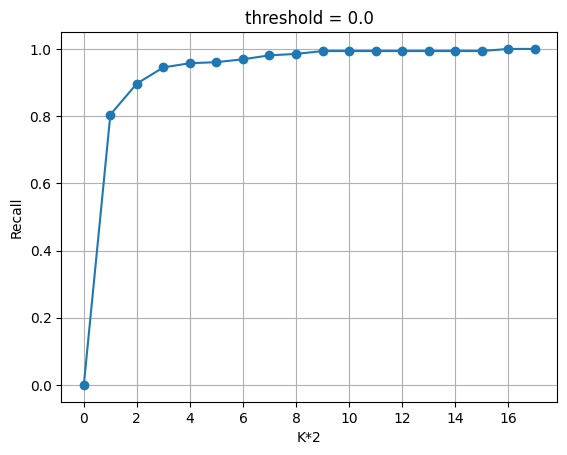

In [ ]:
#plot recall vs K

import matplotlib.pyplot as plt 

#k.insert(0, '1')
x = k
#answers.insert(0,'0.46')
y=answers

plt.xlabel("K*2")
plt.ylabel("Recall")
plt.title('threshold = 0.0')
plt.xticks(range(0, 35, 2))
plt.plot(y, marker = 'o')
plt.grid()
plt.show()  

# Recall 2, MRR and Precision

## Score function based on topic percentage contribution

In [124]:
# Query -> [Candidates, perc contrib]

candidates_percent = query_to_candidates_percent(doc_to_top_k, query_to_dominant, doc_perc_contrib_topics)

#3. Ordenar candidatos em relacao ao Perc_contrib_final decrescente

sorted_dict = {k: sorted(v, key=lambda x: x[1], reverse=True) for k, v in candidates_percent.items()} # (650 items) {'008447.txt': [['008447.txt', 1.0], ['069049.txt', 1.0],...], ...}

#Remove perc contrib :: Create a vector: { Query -> [candidates], query -> [candidates] }
qc_clean = {}
for key, value in sorted_dict.items():
    new_value = []
    for w in value:
        new_value.append(w[0])
    qc_clean[key] = new_value

#remove query dos candidatos
candidates2_final = {k: [x for x in v if x != k] for k, v in qc_clean.items()}



In [ ]:
#DO NOT RUN 
#Ajustar formato do dicionário -- Só precisa rodar se for juntar as funcoes de score
candidates_percent_formated = {}

for chave, lista in candidates_percent.items():
    novo_dicionario = {}
    for item in lista:
        subchave, subvalor = item
        novo_dicionario[subchave] = subvalor
    candidates_percent_formated[chave] = novo_dicionario

## Score based on consine similatiry

In [125]:
ids_to_embeddings = dict(zip(list_of_ids, embeddings_list))
#print(ids_to_embeddings)

query_to_embeddings = convert_doc_ids_to_embeddings(candidates2_final, ids_to_embeddings)
# print(query_to_embeddings)
#write_doc_to_embeddings(query_to_embeddings, "query_to_embeddings")



results_raw=dict()
results_perc = dict()
for key, values in query_to_embeddings.items():
  X = np.array(ids_to_embeddings[key]).reshape(1,-1) #query
  Y = values #candidatos
  similarities = cosine_similarity(X, Y) # query linha, candidato coluna
  sim = similarities[0] # Só tem uma linha, então criou a variável sim pra não ficar tendo que declarar [0] toda hora
  #lenght = 35
  lenght = len(candidates2_final[key]) ##
  ind = np.argpartition(sim, -lenght)[-lenght:] # Diz quem sao os tops dentro desse top X (lenght);
  #ind = np.argpartition(sim, -35)[-35:]   # Pra variar o top N mais similares; pega os N últimos, pq está em ordem crescente;
  top = ind[np.argsort(sim[ind])] # Ordena o vetor;  Retorna o indice (original) dos valores no Top N
  value = list(candidates2_final[key])
  answers_raw= []
  answers = dict()
  for idx in top:
    if value[idx] != key:
      answers_raw.append(value[idx])
      answers[value[idx]] = sim[idx]
  results_perc[key] = answers
  results_raw[key] = answers_raw

#print(results_perc['008447.txt'])


In [59]:
###Encontrar valores mínimos e máximos do dicionario:

values = [inner_dict[item] for inner_dict in results_perc.values() for item in inner_dict]
min_value = min(values)
max_value = max(values)

print(min_value, max_value)

-0.1736774772775368 0.9562921420917129


In [ ]:
#DO NOT RUN THIS, EXCEPT IF YOU ARE RANKING BY N FIRST CANDIDATES
#ORDER THE RESULTS 
results_raw_ordered = results_raw

for chave, valores in results_raw_ordered.items():
    results_raw_ordered[chave] = list(reversed(valores))

x = results_perc
results_ordered = x
for key, values in results_ordered.items():
    results_ordered[key] = list(reversed(values))

#print(results_perc['008447.txt'])
#print(results_ordered['008447.txt'])
#print(results_raw_ordered['008447.txt'])


## join the score functions

In [ ]:
##Normalizar, entre 0 e 1

def normalize_dict_values(dict_values):
    # Encontra o valor mínimo e máximo em todo o dicionário
    min_value = min([min(values.values()) for values in dict_values.values()])
    max_value = max([max(values.values()) for values in dict_values.values()])
    
    # Normaliza os valores do dicionário
    for key, values in dict_values.items():
        for inner_key, value in values.items():
            dict_values[key][inner_key] = (value - min_value) / (max_value - min_value)
    
    return dict_values


normalized_dict_values = normalize_dict_values(results_perc)
#print(normalized_dict_values)

In [ ]:
#Sum both dictionaries: normalized_dict_values and candidates_percent_formated
def unir_dicionarios(dicionario1, dicionario2):
    novo_dicionario = {}
    for chave in set(dicionario1.keys()) | set(dicionario2.keys()):
        if chave in dicionario1 and chave in dicionario2:
            novo_valor = {}
            for subchave, subvalor in dicionario1[chave].items():
                if subchave in dicionario2[chave]:
                    novo_valor[subchave] = subvalor + float(dicionario2[chave][subchave])
                else:
                    novo_valor[subchave] = subvalor
            for subchave, subvalor in dicionario2[chave].items():
                if subchave not in dicionario1[chave]:
                    novo_valor[subchave] = float(subvalor)
            novo_dicionario[chave] = novo_valor
        elif chave in dicionario1:
            novo_dicionario[chave] = dicionario1[chave]
        else:
            novo_dicionario[chave] = dicionario2[chave]
    return novo_dicionario

result_dict_raw = unir_dicionarios(normalized_dict_values,candidates_percent_formated)

#normalize the dict resultante
result_dict = normalize_dict_values(result_dict_raw)

In [ ]:
print(result_dict)

{'008447.txt': {}, '067501.txt': {}, '007627.txt': {}, '006769.txt': {}, '007876.txt': {}, '078422.txt': {}, '000123.txt': {}, '031183.txt': {}, '039087.txt': {}, '008653.txt': {}, '030394.txt': {}, '043815.txt': {}, '053848.txt': {}, '076001.txt': {}, '001499.txt': {}, '006704.txt': {}, '068182.txt': {}, '031284.txt': {}, '046467.txt': {}, '040560.txt': {}, '088711.txt': {}, '078681.txt': {}, '039421.txt': {}, '070711.txt': {}, '050190.txt': {}, '060807.txt': {}, '046017.txt': {}, '093016.txt': {}, '071236.txt': {}, '008771.txt': {}, '087599.txt': {}, '009186.txt': {}, '038947.txt': {}, '046489.txt': {}, '015031.txt': {}, '074582.txt': {}, '000092.txt': {}, '089555.txt': {}, '057136.txt': {}, '015966.txt': {}, '007135.txt': {}, '066194.txt': {}, '079913.txt': {}, '076990.txt': {}, '092332.txt': {}, '024157.txt': {}, '085841.txt': {}, '069872.txt': {}, '007667.txt': {}, '024481.txt': {}, '060686.txt': {}, '099856.txt': {}, '058009.txt': {}, '001510.txt': {}, '069976.txt': {}, '004541.t

In [ ]:
# {'018101.txt': [['007376.txt', 1.4227989888543229], ['045975.txt', 0.6759943596426914], ['076949.txt', -0.33368950906435035]], '040787.txt': [['019072.txt', -0.5143816959383101], ['019052.txt', -0.4356182414141254], ['085818.txt', -0.424140937124176]], '072899.txt': [['014041.txt', -0.1577988276092792]], '027892.txt': [['027525.txt', 0.004904023265825841], ['080529.txt', -0.48770578990365127], ['060193.txt', -0.5663620848125319]], '055899.txt': [['027933.txt', 0.27729926021987816], ['096695.txt', 0.11119097820313961]], ...}

## Cut by a threshold

In [ ]:
threshold_ranking = 0.36

final_candidates = {}
for chave, dicionario_interno in results_perc.items():
    novo_dicionario_interno = {}
    for chave_interna, valor in dicionario_interno.items():
        if valor > threshold_ranking:
            novo_dicionario_interno[chave_interna] = valor
    if novo_dicionario_interno:
        final_candidates[chave] = novo_dicionario_interno

#print(final_candidates)
print(len(final_candidates))

872


In [ ]:
#Order results_perc
results_ordered = results_perc
for key, values in results_ordered.items():
    results_ordered[key] = list(reversed(values))

In [ ]:
##Include missing queries and some candidates
n = 6
def atualiza_dicionario(all_queries, final):
    novos_valores = {}
    for chave in all_queries.keys():
        if chave not in final:
            novos_valores[chave] = all_queries[chave][:n]
    final_atualizado = {**final, **novos_valores}
    return final_atualizado

final_candidates_complete = atualiza_dicionario(results_ordered,final_candidates)


### Calculation for one threshold

In [ ]:
#print('threshold_ranking = ', threshold_ranking)
print(n)
print(k)
print(threshold_ranking)

#RECALL 2
#Calculate Recall
recall_result = recall_micro(final_candidates_complete, doc_to_refs)
#print(recall_result)
#recall_mean = statistics.mean(recall_result.values())
print('recall: ',recall_result)

#write_document_map_to_csv(recall_result,'Final_recall_K=50_x=0.csv')

#Precision
#Calculate Precision
precision_result = precision_micro(final_candidates_complete, doc_to_refs)
#print(precision_result)
#precision_mean = statistics.mean(precision_result.values())
print('precision: ', precision_result)
#write_document_map_to_csv(precision_result,'Final_precision_Kmax.csv')

#Avg f1 score
avg_f1 = f1_score(precision_result,recall_result)
print('avg f1 score: ', avg_f1)


#MRR
#mrr_result = mrr(final_candidates, doc_to_refs)
#mrr_mean = statistics.mean(mrr_result.values())
#print('MRR: ',mrr_mean)
#write_document_map_to_csv(mrr_mean,'mrr_result.csv')



In [ ]:
recall_results= 0
relevants= 0

#denominator
for key, items in doc_to_refs.items():
    relevants = relevants + len(items)
print(relevants)    
for query,candidates in final_candidates_complete.items():
    print(query)
    for candidate in final_candidates_complete[query]:
      if candidate in doc_to_refs[query]:
        recall_results = recall_results+1
        print("relevants: ",recall_results)
#metric calculation
recall = recall_results / relevants
print(recall)

## for many thresholds


In [126]:
#Variar os thresholds 

thresholds_ranking = list(range(36, 49, 1))
thresholds_ranking = [x / 100 for x in thresholds_ranking]
print(thresholds_ranking)

filtered_candidates = []
for h in thresholds_ranking:
    final_candidates = {}
    for chave, dicionario_interno in results_perc.items():
        novo_dicionario_interno = {}
        for chave_interna, valor in dicionario_interno.items():
            if valor > h:
                novo_dicionario_interno[chave_interna] = valor
        if novo_dicionario_interno:
            final_candidates[chave] = novo_dicionario_interno
    filtered_candidates.append(final_candidates)


[0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48]


In [19]:
#Using sorted_dict (ranking function from perc contribuição)

filtered_candidates = []
for h in thresholds_ranking:
    final_candidates = {}
    for chave, dici_interno in sorted_dict.items():
        novo_dicionario_interno = {}
        for chave_interna, valor in dici_interno:
            if float(valor) > h:
                novo_dicionario_interno[chave_interna] = valor
        if novo_dicionario_interno:
            final_candidates[chave] = novo_dicionario_interno
    filtered_candidates.append(final_candidates)


In [127]:
print(thresholds_ranking) 

recall_h = []
precision_h= []
f1_h=[]
for x in filtered_candidates: 
    recall3 = recall_micro(x,doc_to_refs_adjusted)
    #print(recall3)
    precision3 = precision_micro(x,doc_to_refs_adjusted)
    #avg_recall = statistics.mean(recall3.values())
    #avg_precision = statistics.mean(precision3.values())
    avg_f1_h = f1_score(precision3,recall3)
    recall_h.append(recall3)
    #print(avg_recall)
    precision_h.append(precision3)
    f1_h.append(avg_f1_h)
    

for number in recall_h:
  print("{:10.4f}".format(number))
print('\n') 
for number in precision_h:
  print("{:10.4f}".format(number)) 
print('\n') 
for number in f1_h:
  print("{:10.4f}".format(number)) 


mrr_h=[0]
for x in filtered_candidates: 
    try:
        mrr_h = mrr(x,doc_to_refs)
        avg_mrr_h = statistics.mean(mrr_h.values())
        mrr_h.append(avg_mrr_h)
    except:
        continue



[0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48]
    0.3915
    0.3757
    0.3677
    0.3571
    0.3519
    0.3466
    0.3360
    0.3307
    0.3122
    0.2989
    0.2910
    0.2778
    0.2725


    0.1762
    0.1830
    0.1952
    0.2049
    0.2163
    0.2270
    0.2378
    0.2485
    0.2532
    0.2574
    0.2670
    0.2734
    0.2830


    0.2430
    0.2461
    0.2550
    0.2604
    0.2679
    0.2743
    0.2785
    0.2838
    0.2796
    0.2766
    0.2785
    0.2756
    0.2776


## Metrics calculation : plots

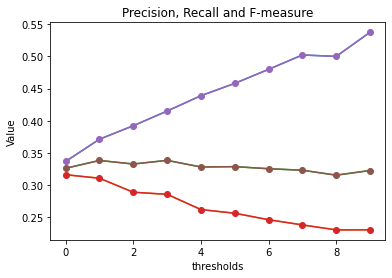

In [ ]:
0#plot recall and precision vs K

import matplotlib.pyplot as plt 

plt.plot(precision_h, label="Precision")
plt.plot(recall_h, label="Recall")
plt.plot(f1_h, label="F1 score")


plt.title("Precision, Recall and F-measure")
plt.xlabel("thresholds")
plt.ylabel("Value")
plt.plot(recall_h, marker = 'o')
plt.plot(precision_h, marker = 'o')
plt.plot(f1_h, marker = 'o')

In [ ]:
print(filtered_candidates[0])
print(filtered_candidates[1])

{'008447.txt': {'049315.txt': 0.36563653638588545, '040639.txt': 0.3666861142974176, '017617.txt': 0.36758474394354607, '095905.txt': 0.3719316014559422, '025271.txt': 0.37686710108980254, '065296.txt': 0.37960210714979764, '004851.txt': 0.3853211650327915, '020730.txt': 0.397139639785318, '075040.txt': 0.41440678996476177, '041229.txt': 0.4244638822965068, '069049.txt': 0.4792551270352088, '089987.txt': 0.9445169537923337}, '067501.txt': {'049784.txt': 0.42096150457770054, '072553.txt': 0.43614653286022687, '033703.txt': 0.5707207561288703, '028189.txt': 0.5937970691368653, '039086.txt': 0.6041463717860113, '038025.txt': 0.6072286371875715, '030050.txt': 0.8822390804927908, '063530.txt': 0.8892001131390324}, '007627.txt': {'095783.txt': 0.36388566240136283, '039317.txt': 0.36399823461812764, '089043.txt': 0.36799531278023206, '085737.txt': 0.37570800005291116, '027411.txt': 0.37879999268760567, '027629.txt': 0.4011631920944114, '046467.txt': 0.411118241993515, '020968.txt': 0.41319135

In [ ]:
print(len(results_raw_ordered['008447.txt']))

2529


## Analysis to many K's

In [ ]:
#Vary K from x to y, adding 5
k = list(range(0,125,5))

#define threshold 
threshold = 0.0

#generate many maps 
top_k = []
for z in k:
    map = generate_top_k_map_threshold(bert_result_file,z,threshold)
    top_k.append(map)

candidates_final_ks = []
for key in top_k:
    candidates_percentage = query_to_candidates_percent(key, query_to_dominant, doc_perc_contrib_topics)
    sorted_dicti = {k: sorted(v, key=lambda x: x[1], reverse=True) for k, v in candidates_percentage.items()}
    qc_clean_ks = {}
    for key, value in sorted_dicti.items():
        new_value = []
        for w in value:
            new_value.append(w[0])
        qc_clean_ks[key] = new_value
    candidates_final = {k: [x for x in v if x != k] for k, v in qc_clean_ks.items()}
    candidates_final_ks.append(candidates_final)
    

In [ ]:
recall_ks = [0]
precision_ks= [0]
for x in candidates_final_ks: 
    try:
        #recall_2 = recall(x,doc_to_refs)
        recall_2 = recall_micro(x,doc_to_refs)
        #precision_2 = precision(x,doc_to_refs)
        precision_2 = precision_micro(x,doc_to_refs)
        #avg_recall_2 = statistics.mean(recall_2.values())
        #avg_precision_2 = statistics.mean(precision_2.values())
        #recall_ks.append(avg_recall_2)
        recall_ks.append(recall_2)
        #precision_ks.append(avg_precision_2)
        precision_ks.append(precision_2)
    except:
        continue

for number in recall_ks:
  print("{:10.4f}".format(number))
print('\n') 
for number in precision_ks:
  print("{:10.4f}".format(number)) 


#f__score=[0]
#for p in precision_ks:
#    for r in recall_ks:
#        f_score = f1_score(p,r)
#        f__score.append(f_score)
#        continue
    
#for number in f__score:
#    print(number) 

#f1 = (2*precision*recall)/(precision+recall)

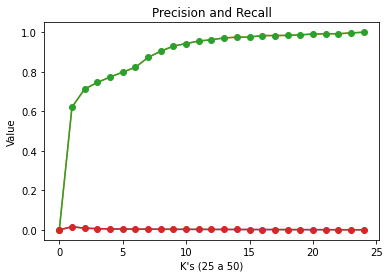

In [ ]:
#plot recall and precision vs K

import matplotlib.pyplot as plt 

plt.plot(precision_ks, label="Precision")
plt.plot(recall_ks, label="Recall")

plt.title("Precision and Recall")
plt.xlabel("K's (25 a 50)")
plt.ylabel("Value")
plt.plot(recall_ks, marker = 'o')
plt.plot(precision_ks, marker = 'o')

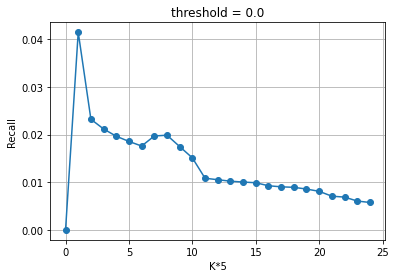

In [ ]:
#plot MRR vs K

import matplotlib.pyplot as plt 

#k.insert(0, '1')
x = k
#answers.insert(0,'0.46')
y=mrr_ks

plt.xlabel("K*5")
plt.ylabel("Recall")
plt.title('threshold = 0.0')
plt.plot(y, marker = 'o')
plt.grid()
plt.show()  

## Analysis to many N's

In [ ]:
ids_to_embeddings = dict(zip(list_of_ids, embeddings_list))
query_to_embeddings = convert_doc_ids_to_embeddings(candidates2_final, ids_to_embeddings)


#Variar N's (k fixo)
N = list(range(0,10,1))

candidates_final_N = []
for n in N:
    results_raw_N=dict()
    results_N = dict()
    for key, values in query_to_embeddings.items():
        x = np.array(ids_to_embeddings[key]).reshape(1,-1) #query
        y = values #candidatos
        similarities = cosine_similarity(x, y) # query linha, candidato coluna
        simi = similarities[0] # Só tem uma linha, então criou a variável sim pra não ficar tendo que declarar [0] toda hora
        #lenght = 35
        #lenght = len(doc_to_refs[key]) ##
        #ind = np.argpartition(sim, lenght)[lenght:] # Diz quem sao os tops dentro desse top X (lenght);
        indi = np.argpartition(simi, -n)[-n:]   # Pra variar o top N mais similares; pega os N últimos, pq está em ordem crescente;
        topi = indi[np.argsort(simi[indi])] # Ordena o vetor;  Retorna o indice (original) dos valores no Top N
        value = list(candidates2_final[key])
        answers_raw_N= []
        answers_N = dict()
        for idx in topi:
            if value[idx] != key:
                answers_raw_N.append(value[idx])
                answers_N[value[idx]] = simi[idx]
        results_N[key] = answers_N
        results_raw_N[key] = answers_raw_N
        results_raw_ordered_N = results_raw_N
        for chave, valores in results_raw_ordered_N.items():
            results_raw_ordered_N[chave] = list(reversed(valores))
    candidates_final_N.append(results_raw_ordered_N)




In [ ]:
#print(len(candidates_final_N[0]['008447.txt']))
print(N)
print(k)

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
50


### Metrics calculation

In [ ]:
recall_Ns = [0]
precision_Ns= [0]
f1_Ns=[0]
for x in candidates_final_N:
    recall_N = recall_micro(x,doc_to_refs)
    precision_N = precision_micro(x,doc_to_refs)
    #avg_recall_N = statistics.mean(recall_N.values())
    #avg_precision_N = statistics.mean(precision_N.values())
    avg_f1_N = f1_score(precision_N,recall_N)
    recall_Ns.append(recall_N)
    precision_Ns.append(precision_N)
    f1_Ns.append(avg_f1_N)
    

for number in recall_Ns:
  print("{:10.4f}".format(number))
print('\n') 
for number in precision_Ns:
  print("{:10.4f}".format(number)) 
print('\n') 
for number in f1_Ns:
  print("{:10.4f}".format(number)) 


mrr_Ns=[0]
for x in candidates_final_N: 
    try:
        mrr_N = mrr(x,doc_to_refs)
        avg_mrr_N = statistics.mean(mrr_N.values())
        mrr_N.append(avg_mrr_N)
    except:
        continue



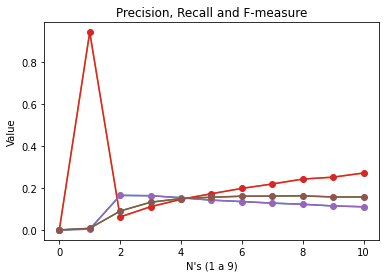

In [ ]:
#plot recall, precision and f1 score vs K

import matplotlib.pyplot as plt 

plt.plot(precision_Ns, label="Precision")
plt.plot(recall_Ns, label="Recall")
plt.plot(f1_Ns, label="F1 score")


plt.title("Precision, Recall and F-measure")
plt.xlabel("N's (1 a 9)")
plt.ylabel("Value")
plt.plot(recall_Ns, marker = 'o')
plt.plot(precision_Ns, marker = 'o')
plt.plot(f1_Ns, marker = 'o')

## Escrever resultado final no txt enviado

In [ ]:
##COLOCAR RESPOSTA NO GABARITO E SALVAR ARQUIVO

d1 = doc_to_refs
d2 = final_candidates
#d1 = {'070318.txt': [], '077960.txt': [], '042319.txt': [], '041766.txt': [], '077407.txt': []}
#d2 = {'042319.txt': {'093691.txt': 0.4633171621704899}, '041766.txt': {'039269.txt': 0.5419708172800757}, '077407.txt': {'038669.txt': 0.38837926918697446, '039348.txt': 0.42561472934332656, '085158.txt': 0.4581642287708543}, '067252.txt': {'059949.txt': 0.40011845160235604}, '021157.txt': {'060210.txt': 0.3889652875653135}}

d3 = {k: [v for v in final_candidates.get(k, {}).keys()] if k in doc_to_refs else [] for k in doc_to_refs.keys()}

print(d3)


# Escreve o novo dicionário em um arquivo de texto no formato JSON
with open("/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/COLIEE_2023/task1_test_files_2023/task1_2023_K50t036.txt", "w") as arquivo:
    json.dump(d3, arquivo)


{'070318.txt': ['062880.txt'], '077960.txt': [], '042319.txt': ['093691.txt'], '041766.txt': ['039269.txt'], '077407.txt': ['033411.txt', '038669.txt', '039348.txt', '085158.txt'], '067252.txt': ['059949.txt'], '007514.txt': [], '047826.txt': [], '021157.txt': ['060210.txt'], '017657.txt': ['013889.txt'], '045562.txt': [], '017502.txt': ['081169.txt', '039319.txt', '028791.txt', '093603.txt', '021081.txt', '065808.txt', '085115.txt', '095649.txt', '018554.txt', '024547.txt'], '034757.txt': ['047660.txt', '012510.txt'], '059126.txt': ['038039.txt', '097852.txt'], '037252.txt': ['069475.txt', '025490.txt'], '039755.txt': ['001589.txt', '025676.txt'], '069618.txt': ['010770.txt', '062612.txt', '080381.txt', '059009.txt', '078190.txt', '060054.txt'], '095164.txt': [], '049064.txt': [], '052753.txt': ['096341.txt', '084522.txt'], '077339.txt': ['022176.txt'], '087944.txt': ['051929.txt', '043593.txt', '098992.txt', '023740.txt', '030815.txt', '055850.txt'], '069089.txt': ['006318.txt', '082

# DEBUG

In [ ]:
#Transformar o arquivo json com o gabarito em um csv cuja coluna 1 sejam as chaves
# e as outras colunas os items de cada chave

import json
import csv

json_file = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/acordaos_similares.json"
csv_file = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/decisoes_stj/acordaos_similares.csv"

def json_to_csv(json_file, csv_file):
    # Abrir o arquivo JSON
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Obter as chaves do dicionário para usar como cabeçalho do CSV
    header = ['Arquivo'] + list(data.values())[0]

    # Criar o arquivo CSV e escrever o cabeçalho
    with open(csv_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header)

        # Escrever cada linha do CSV
        for key, value in data.items():
            row = [key] + value
            writer.writerow(row)

json_to_csv(json_file, csv_file)


In [ ]:
##Pegar a data de publicação de cada documento
import os
import re
import csv

# Define a regex pattern para extrair a data do texto
date_pattern1 = re.compile(r'heard on (\w+ \d{1,2}, \d{4})')
date_pattern2 = re.compile(r'(\w+ \d{1,2}, \d{4})\.$', re.MULTILINE)
#date_pattern3 = re.compile(r'(?<=Federal Court\n)(.*\n)*?\s*(\w+ \d{1,2}, \d{4})\.$', re.MULTILINE)


# Abre o arquivo CSV para escrever as saídas
with open('/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/COLIEE_2023/task1_train_files_2023_final/publication_date.csv', 'w', newline='') as csvfile:
    fieldnames = ['DOC_ID', 'Date']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    # Itera sobre todos os arquivos na pasta atual
    for filename in os.listdir('/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/COLIEE_2023/task1_train_files_2023_final/'):
        if filename.endswith('.txt'):
                with open('/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/COLIEE_2023/task1_train_files_2023_final/'+filename, 'r') as file:
                # Procura a data no arquivo de texto usando a regex
                    text = file.read()
                    match = date_pattern1.search(text)
                    if match:
                    # Escreve a saída no arquivo CSV
                        writer.writerow({'DOC_ID': filename, 'Date': match.group(1)})
                    if not match:
                        match = date_pattern2.search(text)
                        if match:
                            date = match.group(1)
                            writer.writerow({'DOC_ID': filename, 'Date': match.group(1)})

          


In [ ]:
def encontrar_posicao_numero(lista, numero):
    posicoes = {}  # Dicionário para armazenar as posições encontradas
        # Convertemos a string de vetor para uma lista de inteiros
    lista = list(map(int, lista.strip('[]').split()))
        
        # Procuramos a posição do número no vetor
    if numero in lista:
            posicao = [i for i, n in enumerate(lista) if n == numero] 
            posicao =  int(posicao[0])+1
    else:
            posicao = None
    return posicao

print(encontrar_posicao_numero(doc_to_top_k['021733.txt'],56))
doc_to_top_k['021733.txt']

4


'[70 18 74 56 57 21 83 112 113 61 111 25 37 5 52 9 17 62 116 2 89 13 114 28 53 4 88 75 71 79 0 60 95 93 23 104 11 64 82 41 10 110 65 30 15 84 86 8 109 33]'

In [ ]:
def encontrar_posicao_numero(lista, numero):
    posicoes = {}  # Dicionário para armazenar as posições encontradas
        # Convertemos a string de vetor para uma lista de inteiros
    lista = list(map(int, lista.strip('[]').split()))
        
        # Procuramos a posição do número no vetor
    if numero in lista:
            posicao = [i for i, n in enumerate(lista) if n == numero] 
            posicao =  int(posicao[0])+1
    else:
            posicao = None
    return posicao


def position_dominant_inside_top_k(doc_to_dominant_topic: map, doc_to_top_k: map, doc_to_refs: map) -> map:
    result = Counter()
    recall_results = Counter()
    for (doc, v) in doc_to_refs.items(): #([('048771.txt', ['038112.txt', '026070.txt']), (...)])
      try:
        for ref in doc_to_refs[doc]: # ['038112.txt', '026070.txt']
          query_dominant = doc_to_dominant_topic[doc] #13
          top_k_from_ref = doc_to_top_k[ref].replace("[","").replace("]","").split(' ') # ['94', '5', '105', '3', '20']
          if (convert_float_to_int_string(query_dominant) in top_k_from_ref):
            result[doc] = result[doc] + encontrar_posicao_numero(doc_to_top_k[ref],query_dominant)
            recall_results[doc] = recall_results[doc] +1
      except:
        result[doc] = result[doc] + 0     
      try:
          result[doc] = result[doc] / recall_results[doc]
      except:
          continue
    return result

Avg_position_candidates = position_dominant_inside_top_k(doc_to_dominant_topic, doc_to_top_k, doc_to_refs)
write_document_map_to_csv(Avg_position_candidates, "posicao_do_dominante_nos_candidatos-por_query.csv")


To write at file: /content/drive/MyDrive/Colab-Notebooks/luisa-novaes/COLIEE_2023/posicao_do_dominante_nos_candidatos-por_query.csv


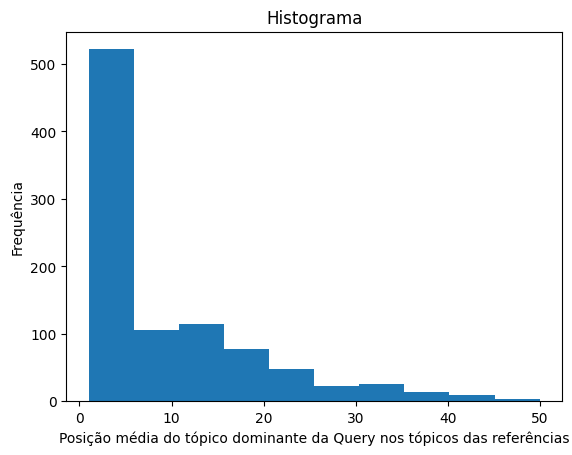

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Criar uma lista com os valores do dicionário
values = list(Avg_position_candidates.values())

# Plotar o histograma
plt.hist(values, bins=10)
plt.xlabel('Posição média do tópico dominante da Query nos tópicos das referências')
plt.ylabel('Frequência')
plt.title('Histograma')
plt.show()

In [ ]:
def atualiza_dicionario(candidatos, final):
    novos_valores = {}
    for chave in candidatos.keys():
        if chave not in final:
            novos_valores[chave] = candidatos[chave][:2]
    final_atualizado = {**final, **novos_valores}
    return final_atualizado

novo_dici = atualiza_dicionario(results_perc,final_candidates)
#novo_dici2 = atualiza_dicionario(candidates2_final,final_candidates)



In [ ]:
#(176 items) ['066101.txt', '024409.txt', '024409.txt', '069228.txt', '061177.txt', ...]

print(novo_dici['066101.txt'])
print(novo_dici2['066101.txt'])
print(novo_dici['024409.txt'])
print(novo_dici2['024409.txt'])

print(novo_dici)
#print(novo_dici['069228.txt'])
#print(novo_dici['061177.txt'])

['078407.txt', '085285.txt']
['007225.txt', '062470.txt']
['021416.txt', '024341.txt']
['048338.txt', '070346.txt']
{'028914.txt': {'038765.txt': 0.4157462064324562}, '037011.txt': {'093139.txt': 0.49024841926653223, '095979.txt': 0.626816719643563}, '093729.txt': {'010101.txt': 0.411858267191794, '092405.txt': 0.4191021954397223, '063237.txt': 0.4528817128040023}, '092346.txt': {'020537.txt': 0.7460032222577955}, '050332.txt': {'035406.txt': 0.41138175380220054, '062748.txt': 0.41193001329350454, '068864.txt': 0.4463524973537188, '047371.txt': 0.4594649204519212, '015764.txt': 0.5432207234493711, '092292.txt': 0.5875044627411925, '049239.txt': 0.6699240890056154}, '051749.txt': {'052082.txt': 0.5662067908359076}, '020351.txt': {'002388.txt': 0.48381371065147405}, '063855.txt': {'021520.txt': 0.4421097248936205}, '076286.txt': {'029207.txt': 0.41154387117984326, '084324.txt': 0.4222090959026857, '092405.txt': 0.43503398023627504, '085296.txt': 0.4379623321435474, '062422.txt': 0.442383

In [ ]:

#print('threshold_ranking = ', threshold_ranking)
print(k)
print(threshold_ranking)

#RECALL 2
#Calculate Recall
recall_result = recall_micro(novo_dici, doc_to_refs)
print('recall: ',recall_result)

#Precision
#Calculate Precision
precision_result = precision_micro(novo_dici, doc_to_refs)
print('precision: ', precision_result)


#Avg f1 score
avg_f1 = f1_score(precision_result,recall_result)
print('avg f1 score: ', avg_f1)



50
0.4
recall:  0.1309840425531915
precision:  0.3203252032520325
avg f1 score:  0.18593676262387918


In [ ]:
#DEBUG RECALL
#final_candidates
#novo_dici

#final_candidates evaluation
recall_results= 0
relevants= 0
for query,candidates in novo_dici.items():
    for candidate in novo_dici[query]:
      if candidate in doc_to_refs[query]:
        recall_results = recall_results+1
for key, items in doc_to_refs.items():
    relevants = relevants + len(items)
print("retrieved_cases:", recall_results)
recall = recall_results / relevants
print("final recall = ", recall)

retrieved_cases: 197
final recall =  0.1309840425531915


In [ ]:
recall_results= 0
relevants= 0

#denominator
for key, items in doc_to_refs.items():
    relevants = relevants + len(items)
print(relevants)    
for query,candidates in final_candidates_complete.items():
    print(query)
    for candidate in final_candidates_complete[query]:
      if candidate in doc_to_refs[query]:
        recall_results = recall_results+1
        print("relevants: ",recall_results)
#metric calculation
recall = recall_results / relevants
print(recall)

In [ ]:
final_candidates_complete

for key, items in final_candidates_complete.items():
    relevants = relevants + len(items)
    print(key)
    print(relevants)


In [ ]:
#DEBUG
#List of candidates (recall 1)


#ALTERNATIVA 1: Avaliar a presença do tópico dominante da QUERY nos top k tópicos dominantes da RESPOSTA 
#Gerar listas de docs que possuem o tópico dominante z da query no Top k, e a porc de contrib desse topico
def candidates_phase_1(documents_topk_map, query_to_dominant):
    filtered_candidates = dict()
    for (query, query_topic) in query_to_dominant.items(): #{028184.txt: 3, 028324.txt 19, ...}
        answers=[]
        for (candidate, topk) in documents_topk_map.items():
            top_k_candidates = topk.replace("[","").replace("]","").split() # ['94', '5', '105', '3', '20']
            if (convert_float_to_int_string(query_topic) in top_k_candidates):
                answers.append(candidate)
            else:
                continue
            filtered_candidates[query] = answers
    return filtered_candidates  

candidates_1 = candidates_phase_1(doc_to_top_k_threshold, query_to_dominant)

recall_1 = recall(candidates_1, doc_to_refs)
print(recall_1)
#write_document_map_to_csv(candidates2_final, "candidates_recall_2.csv")



In [ ]:
print(doc_to_refs['016020.txt'])
print(query_to_dominant['016020.txt'])
print(doc_to_dominant_topic['016020.txt'])


for k in doc_to_refs['016020.txt']:
    print(k, doc_to_top_k_threshold[k])


['077064.txt', '072786.txt', '050167.txt', '054993.txt', '025277.txt', '025277.txt']
42
42.0
077064.txt [97 118 42 75 2 98 116 69 115 107 84 44 7 55 63 40 111 77 70 88 106 93 11 37 21 26 52 51 102 28 58 67 62 25 113 29 54 1 60 114 56 33 20 101 66 18 10 89 46 119]
072786.txt [118 97 75 42 98 116 69 84 2 115 55 44 107 40 7 77 63 111 70 88 106 93 37 21 11 52 26 51 102 28 62 58 25 67 113 29 54 1 60 114 56 33 20 66 101 18 10 46 89 119]
050167.txt [42 116 69 84 118 97 75 40 98 2 107 7 115 63 44 111 55 77 70 88 26 37 11 106 93 21 52 51 102 28 62 58 67 25 113 29 54 1 60 56 114 18 33 20 66 101 10 89 46 119]
054993.txt [118 97 75 42 98 116 2 69 115 84 55 44 107 40 77 7 63 111 70 88 106 93 21 37 11 52 51 102 26 28 62 58 67 25 113 29 54 1 60 114 56 33 20 101 66 18 10 46 89 119]
025277.txt [97 118 2 42 75 115 107 98 116 69 7 55 84 44 111 77 63 40 70 93 106 11 88 21 37 52 51 28 102 58 26 62 67 25 113 29 54 1 60 114 33 56 20 101 66 10 18 46 89 119]
025277.txt [97 118 2 42 75 115 107 98 116 69 7 55 84

In [ ]:
print(candidates2_final['031336.txt'])

x = 0
for k in doc_to_refs['031336.txt']:
    if k in candidates2_final['031336.txt']:
        indice = candidates2_final['031336.txt'].index(k)
        print(k)
        print(indice)
       


#doc_to_refs['096245.txt'] = ['068014.txt', '067869.txt']
#doc_to_refs['039769.txt'] = ['071525.txt', '076034.txt']
#doc_to_refs['031336.txt'] = ['083834.txt', '007483.txt']


['007876.txt', '078422.txt', '000123.txt', '039087.txt', '030394.txt', '004108.txt', '040560.txt', '038947.txt', '046489.txt', '000092.txt', '057136.txt', '066194.txt', '024481.txt', '099856.txt', '077380.txt', '029645.txt', '068503.txt', '014909.txt', '022731.txt', '055208.txt', '042691.txt', '007137.txt', '040239.txt', '046080.txt', '000669.txt', '096028.txt', '011450.txt', '076365.txt', '056717.txt', '037710.txt', '046478.txt', '096651.txt', '056962.txt', '064109.txt', '003865.txt', '005830.txt', '056909.txt', '014411.txt', '080529.txt', '040801.txt', '096695.txt', '062926.txt', '098780.txt', '042705.txt', '003595.txt', '078779.txt', '016058.txt', '041233.txt', '037440.txt', '064402.txt', '076969.txt', '023818.txt', '046310.txt', '079200.txt', '053170.txt', '091318.txt', '050528.txt', '098080.txt', '086250.txt', '013201.txt', '043843.txt', '071437.txt', '080552.txt', '048477.txt', '060404.txt', '064116.txt', '000085.txt', '072292.txt', '093729.txt', '092346.txt', '050332.txt', '0203

In [ ]:
doc_to_ref = {"016165.txt": ["085548.txt", "003243.txt", "007780.txt", "065702.txt"], '018383.txt': ['080510.txt', '065005.txt', '069405.txt', '030980.txt', '083650.txt'], '096245.txt':  ['068014.txt', '067869.txt'], '039769.txt': ['071525.txt', '076034.txt']}
#"016165.txt": ["085548.txt", "003243.txt", "007780.txt", "065702.txt"] # precision = 1/3; recall: 1/4 
#'018383.txt': ['080510.txt', '065005.txt', '069405.txt', '030980.txt', '083650.txt'] # precision = 3/6 ; recall = 3/5
#'096245.txt': ['068014.txt', '067869.txt'] #precision = 0/2 ; recall = 0/2 
#'039769.txt': ['071525.txt', '076034.txt'] #precision = 1/3 ; recall = 1/2 
## retrieved: 14
## relevants_total: 13
## relevants returned: 5

final_candidates = {"016165.txt": ["id2", "003243.txt", "id3"], '018383.txt': ['080510.txt', 'id4', 'id5', '030980.txt', '083650.txt', 'id8'], '096245.txt':  ['id4','id8'], '039769.txt': ['id3', '076034.txt', 'id7']}


In [ ]:
p = precision_micro(final_candidates, doc_to_ref)
r = recall_micro(final_candidates, doc_to_ref)
print(p,r)

016165.txt
4
018383.txt
9
096245.txt
11
039769.txt
13
5
0.35714285714285715 0.38461538461538464


In [ ]:
precision = 5/14
recall = 5/13
print(precision,recall)

0.35714285714285715 0.38461538461538464


In [ ]:
#AJUSTAR NOME DOS ARQUIVOS NA PASTA
import os
import datetime

diretorio = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/COLIEE_2023/task1_train_files"

# Obtém a data atual
data_atual = datetime.datetime.now().strftime('%Y-%m-%d')

# Itera por todos os arquivos na pasta
for arquivo in os.listdir(diretorio):
    novo_nome = arquivo.replace(' (1)', '')
# Renomeia o arquivo
    os.rename(os.path.join(diretorio, arquivo), os.path.join(diretorio, novo_nome))

In [ ]:
#GERAR DICIONÁRIO das queries de arquivo json via funcão

#queries -> answers ; 650 items; {'008447.txt': ['072495.txt', '082291.txt',...]...} #TRAIN SET; TEST SET W/ 250 items
#doc_to_refs = generate_document_map("/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/COLIEE_2023/task1_train_labels_2023.json")  


In [ ]:

### Def Precision geral (Relevant/Documents : Denominator = Number of candidates )
def precision_micro(qc_final_clean, queries_to_refs) -> map:
    precision_results= 0
    retrieved_cases = 0
    for query,candidates in qc_final_clean.items():
      retrieved_cases = retrieved_cases + len(qc_final_clean[query])
      #print(query)
      #print(retrieved_cases)
      for candidate in qc_final_clean[query]:
        if candidate in queries_to_refs[query]:
          precision_results= precision_results +1
      #print(precision_results)
    precision = precision_results / retrieved_cases
    return precision

### Def Recall geral (Relevants/Total of Relevants : Denominator = Number of Relevants)
def recall_micro(qc_final_clean, queries_to_refs) ->map:
  recall_results= 0
  relevants= 0
  for query,candidates in qc_final_clean.items():
    relevants = relevants + len(queries_to_refs[query])
    print(query)
    print(relevants)
    for candidate in qc_final_clean[query]:
      if candidate in queries_to_refs[query]:
        recall_results = recall_results+1
  print(recall_results)
  recall = recall_results / relevants
  return recall   


###Gerar datasets treino e teste


In [ ]:
import json
import random

def generate_train_test_sets(source, num_sets):
    all_keys = list(source.keys())
    num_keys = len(all_keys)
    test_size = int(0.3 * num_keys)
    train_size = num_keys - test_size
    #assert train_size >= 67 and test_size >= 158, "Número insuficiente de chaves para formar os conjuntos"
    
    # Gerar num_sets conjuntos de treino e teste
    for i in range(1, num_sets+1):
        # Selecionar aleatoriamente as chaves para treino e teste
        test_keys = set(random.sample(all_keys, test_size))
        train_keys = set(all_keys) - test_keys
        
        # Verificar se não há chaves em comum entre os conjuntos de treino e teste
        assert len(train_keys.intersection(test_keys)) == 0, "Chaves repetidas em treino e teste"
        
        # Gerar os subconjuntos de treino e teste
        train_dict = {}
        test_dict = {}
        for key, values in source.items():
            if key in train_keys:
                train_dict[key] = values
            elif key in test_keys:
                test_dict[key] = values
        
        # Salvar os subconjuntos em arquivos JSON
        with open(f'/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/sbbd_decisoes_stj/treino_{i}.json', 'w') as f:
            json.dump(train_dict, f)
        with open(f'/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/sbbd_decisoes_stj/teste_{i}.json', 'w') as f:
            json.dump(test_dict, f)
        
        print(f'Conjunto {i} gerado com sucesso!')
        print(len(train_dict))
        print(len(test_dict))

source = doc_to_refs
num_sets = 10
generate_train_test_sets(source, num_sets)


### Ajuste pastas

In [ ]:
#Criar pastas a partir dos JSONs de TESTE

import os
import json
import shutil

json_path = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/sbbd_decisoes_stj/teste_2.json"
source_folder = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/sbbd_decisoes_stj/decisoes_stj"
destination_folder = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/sbbd_decisoes_stj/documents"

import os
import json
import shutil

def copy_documents(json_path, source_folder, destination_folder):
    # Carregar o arquivo JSON
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Criar a pasta de destino com o nome do JSON
    destination_folder_json = os.path.join(destination_folder, os.path.splitext(os.path.basename(json_path))[0])
    os.makedirs(destination_folder_json, exist_ok=True)

    # Criar a pasta "train"
  #  destination_folder_train = os.path.join(destination_folder, "treino_2")
  #  os.makedirs(destination_folder_train, exist_ok=True)

    # Copiar os documentos mencionados no JSON para a pasta correspondente
    for filename, related_files in data.items():
        # Copiar o arquivo principal
        try:
            shutil.copy(os.path.join(source_folder, filename), os.path.join(destination_folder_json, filename))
        # Copiar os arquivos relacionados
        except:
            print(filename)
            continue
        for related_file in related_files:
            try:
                shutil.copy(os.path.join(source_folder, related_file), os.path.join(destination_folder_json, related_file))
            except:
                print(related_file)
                continue

    # Copiar os documentos que não estão no JSON para a pasta "train"
  #  for filename in os.listdir(source_folder):
  #      if filename not in data.keys() and filename.endswith('.txt'):
  #          shutil.copy(os.path.join(source_folder, filename), os.path.join(destination_folder_train, filename))

copy_documents(json_path, source_folder, destination_folder)

In [ ]:
##Contar quantos documentos temos na pasta:
import os

def count_txt_files(folder_path):
    count = 0
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            count += 1
    return count

print(count_txt_files("/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/sbbd_decisoes_stj/documents/treino_2"))

1073


In [ ]:
#GERAR DICIONÁRIO das queries

arquivo = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/COLIEE_2023/TRAIN_3/train3_labels.csv"

import csv

def criar_dicionario_a_partir_csv(nome_arquivo):
    dicionario = {}
    with open(nome_arquivo, newline='') as arquivo_csv:
        leitor_csv = csv.reader(arquivo_csv, delimiter=',')
        for linha in leitor_csv:
            chave = linha[0]
            itens = linha[1:]
            if chave in dicionario:
                dicionario[chave].extend(itens)
            else:
                dicionario[chave] = itens
    del dicionario['Document_id']
    
    for chave, itens in dicionario.items():
    # Percorre os itens do conjunto correspondente à chave
        for item in list(itens):
        # Verifica se o item é igual a uma string vazia
            if item == "":
            # Remove o item do conjunto
                itens.remove(item)

    return dicionario

dicionario = criar_dicionario_a_partir_csv(arquivo)

num_itens = 0
for chave in dicionario:
    num_itens += len(dicionario[chave])
print(f"O dicionário possui {num_itens} itens no total.")

#contar quantos valores ÚNICOS
count=0
for key, values in dicionario.items():
    valores_unicos = set(values)
    quantidade_valores_unicos = len(valores_unicos)
    count = count + quantidade_valores_unicos
print(f"O dicionário possui {count} itens únicos no total.")


In [ ]:
import os
import shutil

# Define o dicionário com os nomes dos arquivos
#dicionario

# Define o caminho das pastas X e Y
# X = pasta em que vamos BUSCAR os items
pasta_X = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/COLIEE_2023/task1_train_files_2023_final"
#Y = Pasta em que vamos COLAR os novos items
pasta_Y = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/COLIEE_2023/TRAIN_1"

# Loop para percorrer as chaves e valores do dicionário
for chave, valores in dicionario.items():
    # Verifica se o arquivo da chave está presente na pasta X
    caminho_arquivo_chave = os.path.join(pasta_X, chave)
    if os.path.isfile(caminho_arquivo_chave):
        # Verifica se o arquivo da chave já está presente na pasta Y
        caminho_arquivo_chave_Y = os.path.join(pasta_Y, chave)
        if not os.path.isfile(caminho_arquivo_chave_Y):
            # Copia o arquivo da chave para a pasta Y
            shutil.copy2(caminho_arquivo_chave, pasta_Y)
    
    # Loop para percorrer os valores
    for valor in valores:
        # Verifica se o arquivo do valor está presente na pasta X
        caminho_arquivo_valor = os.path.join(pasta_X, valor)
        if os.path.isfile(caminho_arquivo_valor):
            # Verifica se o arquivo do valor já está presente na pasta Y
            caminho_arquivo_valor_Y = os.path.join(pasta_Y, valor)
            if not os.path.isfile(caminho_arquivo_valor_Y):
                # Copia o arquivo do valor para a pasta Y
                shutil.copy2(caminho_arquivo_valor, pasta_Y)


In [ ]:
import os
#CONFERENCIA PASTAS

#num_arquivos = len([f for f in os.listdir("/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/Coliee_2021") if os.path.isfile(os.path.join("/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/Coliee_2021", f))])
#print('O número de arquivos na pasta é:', num_arquivos)

file_list2 = os.listdir(pasta_Y)
print(len(file_list2))
print(file_list2)

file_list3 = os.listdir("/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/COLIEE_2023/TEST_1")
print(len(file_list3))



2990
['067504.txt', '058938.txt', '060069.txt', '092764.txt', '021347.txt', '039725.txt', '065299.txt', '093486.txt', '075514.txt', '081718.txt', '043298.txt', '048916.txt', '026986.txt', '006476.txt', '028825.txt', '082986.txt', '024358.txt', '086260.txt', '022477.txt', '065459.txt', '075703.txt', '045548.txt', '098891.txt', '065307.txt', '074625.txt', '031557 (1).txt', '069049.txt', '073606.txt', '026188.txt', '052964.txt', '071401.txt', '090172.txt', '097609.txt', '045954.txt', '092363.txt', '070861.txt', '083523.txt', '034039.txt', '060295.txt', '075470.txt', '065677.txt', '087999.txt', '060493.txt', '014660.txt', '093848 (1).txt', '010599.txt', '033960.txt', '071367.txt', '052168.txt', '011086.txt', '082827.txt', '039135.txt', '003530.txt', '003915.txt', '029445.txt', '040964.txt', '059607.txt', '004845.txt', '035108.txt', '017009.txt', '031193.txt', '009430.txt', '012007.txt', '046531.txt', '006304.txt', '057616.txt', '049808.txt', '097817.txt', '038217.txt', '067881.txt', '08647

In [ ]:
#DEBUGAR

#x = dicionario.keys()
#all_candidates = list(x)
all_candidates = file_list2

# Verifica se o valor está presente nas chaves ou nos valores das listas associadas às chaves do dicionário
for chave, valores in dicionario.items():
    if chave not in all_candidates:
        print(f'A chave {chave} não está presente na lista')
        x.append(chave)
    for valor in valores:
        if valor not in all_candidates:
            print(f'O valor {valor} não está presente na lista')
            x.append(chave)

print(len(x))
print(x)


0
[]


In [ ]:

# Conta o número de itens
num_itens = 0
for chave in dicionario:
    num_itens += len(dicionario[chave])
print(f"O dicionário possui {num_itens} itens no total.")


O dicionário possui 3368 itens no total.
660


In [ ]:
import csv

def criar_dicionario_a_partir_csv(nome_arquivo):
    dicionario = {}
    with open(nome_arquivo, newline='') as arquivo_csv:
        leitor_csv = csv.reader(arquivo_csv, delimiter=',')
        for linha in leitor_csv:
            chave = linha[0]
            itens = set(linha[1:])
            dicionario[chave] = itens
    #del dicionario["Document_id"]
    return dicionario

train3_labels = criar_dicionario_a_partir_csv("/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/COLIEE_2023/train3_labels.csv")



# Percorre o dicionário
for chave, itens in dicionario.items():
    # Percorre os itens do conjunto correspondente à chave
    for item in list(itens):
        # Verifica se o item é igual a uma string vazia
        if item == "":
            # Remove o item do conjunto
            itens.remove(item)



In [ ]:
import csv

def criar_dicionario_a_partir_csv(nome_arquivo):
    dicionario = {}
    with open(nome_arquivo, newline='') as arquivo_csv:
        leitor_csv = csv.reader(arquivo_csv, delimiter=',')
        for linha in leitor_csv:
            chave = linha[0]
            itens = linha[1:]
            if chave in dicionario:
                dicionario[chave].extend(itens)
            else:
                dicionario[chave] = itens
    del dicionario['Document_id']
    
    for chave, itens in dicionario.items():
    # Percorre os itens do conjunto correspondente à chave
        for item in list(itens):
        # Verifica se o item é igual a uma string vazia
            if item == "":
            # Remove o item do conjunto
                itens.remove(item)

    return dicionario

train3 = criar_dicionario_a_partir_csv(arquivo)

num_itens = 0
for chave in train3:
    num_itens += len(train3[chave])
print(f"O dicionário possui {num_itens} itens no total.")

O dicionário possui 3382 itens no total.


In [ ]:
#Analise doc_to_refs

# Inicializa as variáveis com a primeira chave do dicionário
chave_maior = list(doc_to_refs.keys())[0]
chave_menor = list(doc_to_refs.keys())[0]

# Itera pelo dicionário e compara o comprimento dos valores associados a cada chave
for chave in doc_to_refs.keys():
    if len(doc_to_refs[chave]) > len(doc_to_refs[chave_maior]):
        chave_maior = chave
    elif len(doc_to_refs[chave]) < len(doc_to_refs[chave_menor]):
        chave_menor = chave

# Imprime as chaves encontradas
print("Chave com o maior número de itens: ", chave_maior, len(doc_to_refs[chave_maior]))

print("Chave com o menor número de itens: ", chave_menor, len(doc_to_refs[chave_menor]))




Chave com o maior número de itens:  099187.txt 34
Chave com o menor número de itens:  001499.txt 1


In [ ]:
soma_comprimentos = 0

# Itera pelo dicionário e soma o comprimento dos valores associados a cada chave
for chave in doc_to_refs.keys():
    soma_comprimentos += len(doc_to_refs[chave])

# Calcula o número médio de itens
numero_medio_itens = soma_comprimentos / len(doc_to_refs)

# Imprime o número médio de itens
print("Número médio de itens: ", numero_medio_itens)

Número médio de itens:  4.679874869655891
